In [21]:
import json
import numpy as np

from matplotlib import pyplot as plt
import matplotlib

In [3]:
dataset = []
with open('data/dataset.json',encoding='utf-8') as file :
    for line in file :
        dataset.append(json.loads(line))

In [4]:
print('Num of dialogs %s' % len(dataset))
print()
print('With kyes : ',dataset[0].keys())

Num of dialogs 4750

With kyes :  dict_keys(['_id', 'dialogId', 'users', 'context', 'thread', 'evaluation'])


In [5]:
#в users ['users'][0]['userType'] содерится тип юзера бот/не бот
print(dataset[0]['users'])

[{'id': '2483750', 'userType': 'org.pavlovai.communication.TelegramChat', 'username': 'yurakuratov'}, {'id': '240141261', 'userType': 'org.pavlovai.communication.TelegramChat', 'username': 'anatoliipotapov'}]


In [6]:
digits = [str(ch) for ch in list(range(10))] # ['0' , '1' , ... ,'9']
rus_letters = [chr(i) for i in range(ord('а'),ord('я')+1)] # ['a' ... 'я']

def get_statistics(dataset,need_print = False,earn_end = True):
    '''
        return statistcs : 
            cnt_thread
            cnt_empty_thread
            cnt_monolog
            cnt_bot_conversations
            cnt_rus_spam
        and list of id for thresh conversentions
    '''
    cnt_empty_thread = 0
    cnt_monolog = 0
    cnt_thread = 0
    cnt_bot_conversations = 0
    cnt_rus_spam = 0
    tresh_conversation_id = []
    
    for i,samle in enumerate(dataset) :

        this_conversation_id = samle['_id']['$oid']
        user1_id = samle['users'][0]['id']
        user2_id = samle['users'][1]['id']
        user1Type = samle['users'][0]['userType']
        user2Type = samle['users'][1]['userType']

        is_user1_bot = user1Type == 'org.pavlovai.communication.Bot'
        is_user2_bot = user2Type == 'org.pavlovai.communication.Bot'

        if is_user1_bot or is_user2_bot :
            cnt_bot_conversations += 1
        
        if need_print :
            print()
            print(i)
            print('Conversatin between : %s(%s)  and %s(%s)' % (user1Type,user1_id,user2Type,user2_id))


        cnt_thread += 1

        if len(samle['thread']) == 0 :
            cnt_empty_thread += 1
            tresh_conversation_id.append(this_conversation_id)
            
            if need_print :
                print('Empty thread')

        else :
            seq_of_userid_speech = []
            seq_of_speach = []
            for phrase in samle['thread']:
                seq_of_userid_speech.append(phrase['userId'])
                seq_of_speach.append(phrase['text'])
                if need_print :
                    print(phrase)
            
            #cnt_rus_spam
            join_text = ''.join(seq_of_speach)
            total_char = len(join_text)
            cnt_rus_letter = 0
            for char in join_text :
                if char in rus_letters :
                    cnt_rus_letter += 1
            if (cnt_rus_letter / total_char) > 0.01 :
                cnt_rus_spam += 1
                tresh_conversation_id.append(this_conversation_id)
                    
            #cnt_monolog
            if len(np.unique(seq_of_userid_speech)) == 1 :
                cnt_monolog += 1
                tresh_conversation_id.append(this_conversation_id)
            
        if earn_end and i == 5000 :
            break

    tresh_conversation_id = np.unique(tresh_conversation_id)
    tresh_conversation_id = list(tresh_conversation_id)
    return cnt_thread,cnt_empty_thread,cnt_monolog,cnt_bot_conversations,cnt_rus_spam,tresh_conversation_id


In [7]:
cnt_thread,cnt_empty_thread,cnt_monolog,cnt_bot_conversations,cnt_rus_spam,tresh_conversation_id =\
    get_statistics(dataset,need_print = False,earn_end = False)

In [8]:
print('Total thread : %s' % cnt_thread)
print('Cnt of epmy thread : %s (%f) ' % (cnt_empty_thread, cnt_empty_thread / cnt_thread))
print('Cnt of monolog : %s (%f)'% (cnt_monolog, cnt_monolog / cnt_thread))
print('Cnt of rus spam : %s (%f)' % (cnt_rus_spam, cnt_rus_spam / cnt_thread))
print('Cnt of total tresh : %s (%f)' %  (len(tresh_conversation_id), len(tresh_conversation_id) / cnt_thread))


print()
print('Cnt of bot conversation : %s (%f)' % (cnt_bot_conversations, cnt_bot_conversations / cnt_thread))

Total thread : 4750
Cnt of epmy thread : 272 (0.057263) 
Cnt of monolog : 1125 (0.236842)
Cnt of rus spam : 176 (0.037053)
Cnt of total tresh : 1533 (0.322737)

Cnt of bot conversation : 3070 (0.646316)


In [9]:
def clean_up_dataset(dataset,tresh_conversation_id) :
    ''' 
    return dataset without tresh_conversation_id conversation
    '''
    dataset_new = []
    for sample in dataset :
        this_conversation_id = sample['_id']['$oid']
        if not (this_conversation_id in tresh_conversation_id) :
            dataset_new.append(sample)
    return dataset_new

In [10]:
dataset_new = clean_up_dataset(dataset,tresh_conversation_id)

In [11]:
def get_pharaze_statistics(dataset):
    '''
    return 
        conversation_length = []     #длина диалгоа (в ко-во фраз)
        conversation_cnt_word = []   #количество слов в диалоге
        conversation_cnt_chr = []    #количество символов в диалоге
    '''

    conversation_length = []     #длина диалгоа (в ко-во фраз)
    conversation_cnt_word = []   #количество слов в диалоге
    conversation_cnt_chr = []    #количество символов в диалоге

    for sample in dataset :        
        thread_length = len(sample['thread'])
        conversation_length.append(thread_length)

        word_cnt = len(' '.join([thread['text'] for thread in sample['thread']]).split(' '))
        conversation_cnt_word.append(word_cnt)

        chr_cnt = len(''.join([thread['text'] for thread in sample['thread']]))
        conversation_cnt_chr.append(chr_cnt)
    
    return conversation_length,conversation_cnt_word,conversation_cnt_chr
    
    
def get_percentiles(dataset, q = [10,90]) :

    conversation_length,conversation_cnt_word,conversation_cnt_chr = get_pharaze_statistics(dataset)
    
    conversation_length_percentile = np.percentile(conversation_length,q)
    conversation_cnt_word_percentile = np.percentile(conversation_cnt_word,q)
    conversation_cnt_chr_percentile = np.percentile(conversation_cnt_chr,q)
    
    return conversation_length_percentile,conversation_cnt_word_percentile,conversation_cnt_chr_percentile

In [12]:
conversation_length_percentile,conversation_cnt_word_percentile,conversation_cnt_chr_percentile = \
                                                                                        get_percentiles(dataset_new,q= [5,95])
print('conversation_length_percentile %s' % conversation_length_percentile)
print('conversation_cnt_word_percentile %s' % conversation_cnt_word_percentile)
print('conversation_cnt_chr_percentile %s' % conversation_cnt_chr_percentile)

conversation_length_percentile [ 3. 34.]
conversation_cnt_word_percentile [ 11.  213.2]
conversation_cnt_chr_percentile [  53.  1088.4]


In [13]:
def get_tresh_id_by_persentrils(dataset,conversation_length_percentile,\
                                conversation_cnt_word_percentile,conversation_cnt_chr_percentile)  :
    tresh_ids = []
    for sample in dataset :
        
        this_conversation_id = sample['_id']['$oid']
        
        thread_length = len(sample['thread'])
        word_cnt = len(' '.join([thread['text'] for thread in sample['thread']]).split(' '))
        chr_cnt = len(''.join([thread['text'] for thread in sample['thread']]))
        
        if ((thread_length < conversation_length_percentile[0] or thread_length > conversation_length_percentile[1]) or 
           (word_cnt < conversation_cnt_word_percentile[0]     or word_cnt > conversation_cnt_word_percentile[1]) or
           (chr_cnt <  conversation_cnt_chr_percentile[0]      or chr_cnt > conversation_cnt_chr_percentile[1] )):
            tresh_ids.append(this_conversation_id)
    return  tresh_ids

In [14]:
tresh_conversation_id2 = get_tresh_id_by_persentrils(dataset_new,conversation_length_percentile,\
                                                    conversation_cnt_word_percentile,conversation_cnt_chr_percentile)

In [15]:
dataset_new2 = clean_up_dataset(dataset_new,tresh_conversation_id2)

In [16]:
print('Total thread : %s' % cnt_thread)
print('Final threads cnt %s (%f)' % (len(dataset_new2), len(dataset_new2) / cnt_thread ))

Total thread : 4750
Final threads cnt 2759 (0.580842)


In [17]:
with open('dataset_cleanup.json','w',encoding='utf-8') as file :
    json.dump(dataset_new2,file)

In [18]:
with open('dataset_cleanup.json',encoding='utf-8') as file :
    tmp = json.load(file)

# Сбор статистики по всем данным

In [19]:
for name,dset in [('dataset_mipt',dataset),('dataset_mipt_ceanup',dataset_new2)] :
    print('Info for %s' % name)
    print('Dialog count : %s' % len(dset))
    
    conversation_length,conversation_cnt_word,conversation_cnt_chr = get_pharaze_statistics(dset)
    print('Average phraze in dialogue  : %s' % np.average(conversation_length))
    print('Average count of word in dialogue : %s' % np.average(conversation_cnt_word))
    print('Average count of char in dialogue : %s' % np.average(conversation_cnt_chr))
    print()

Info for dataset_mipt
Dialog count : 4750
Average phraze in dialogue  : 10.577052631578947
Average count of word in dialogue : 63.792
Average count of char in dialogue : 343.8698947368421

Info for dataset_mipt_ceanup
Dialog count : 2759
Average phraze in dialogue  : 12.851032982964842
Average count of word in dialogue : 76.43457774555999
Average count of char in dialogue : 386.3399782529902



In [54]:
matplotlib.rcParams.update({'font.size': 32})

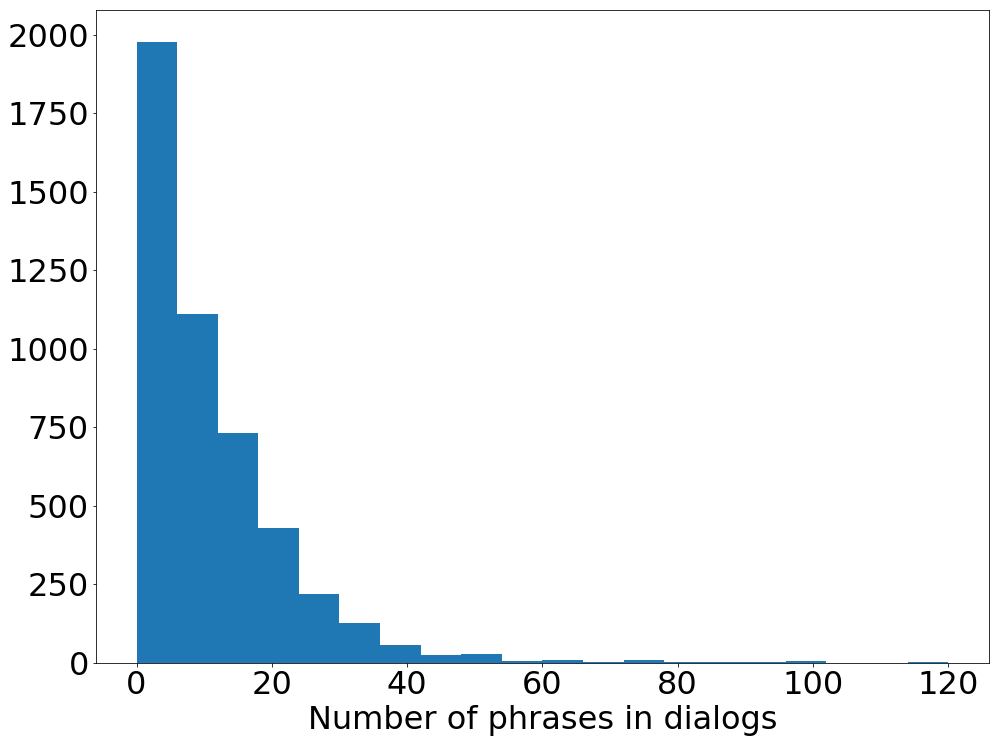

In [55]:
conversation_length,_,_ = get_pharaze_statistics(dataset)

plt.figure(figsize=(16,12))
plt.hist(conversation_length,bins=20)
plt.xlabel('Number of phrases in dialogs')
plt.savefig('img/dataset1.pdf',format='pdf')
plt.show()

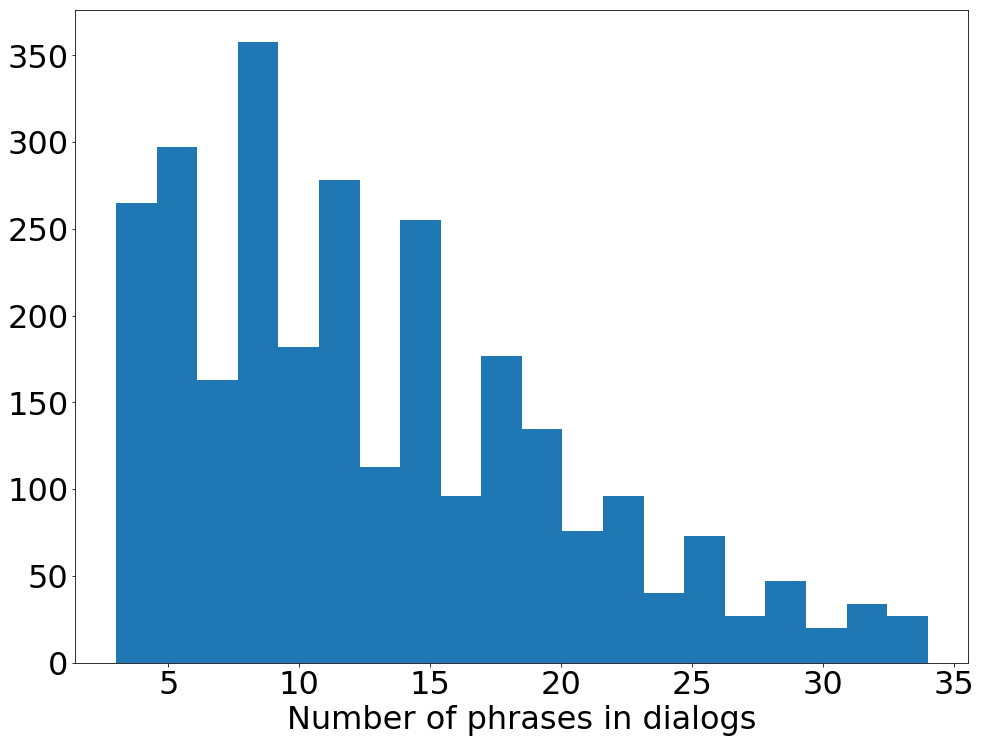

In [56]:
conversation_length,_,_ = get_pharaze_statistics(dataset_new2)

plt.figure(figsize=(16,12))  
plt.hist(conversation_length,bins=20)
plt.xlabel('Number of phrases in dialogs')
plt.savefig('img/dataset1_cleanup.pdf',format='pdf')
plt.show()